In [170]:
## this is the phase 3 of the project

## first we will import the required functions from the utils file 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sfm_utils import (
    load_gray_image,
    build_intrinsics_from_image_size,
    get_feature_extractor,   # this is the SIFT/ORB selector we wrote
)

# Dataset path (same as before)
DATASET_DIR = r"C:\Users\pc\OneDrive\Desktop\CV_Project\dataset2"


In [171]:
# Collect image filenames
# We already know images are 1.jpeg, 2.jpeg, ..., N.jpeg
N_IMAGES = 63
image_names = [f"{i}.jpeg" for i in range(1, N_IMAGES + 1)]

print(f"[INFO] Using {N_IMAGES} sequentially numbered images.")
print(image_names[:10])

# ---- Build K_iphone from FIRST image resolution ----
first_img = load_gray_image(DATASET_DIR, image_names[0])
h, w = first_img.shape[:2]
print("Working image size:", w, "x", h)

# iPhone EXIF info
f35 = 19.0               # FocalLengthIn35mmFilm from EXIF
sensor_width_35mm = 36.0 # mm, standard 35mm frame width

# fx = fy = (f35 / sensor_width_35mm) * w
# cx = w / 2.0
# cy = h / 2.0

# K = np.array([
#     [fx, 0.0, cx],
#     [0.0, fy, cy],
#     [0.0, 0.0, 1.0]
# ], dtype=np.float64)
img1_name = "1.jpeg"
img2_name = "2.jpeg"

img1 = load_gray_image(DATASET_DIR, img1_name)
img2 = load_gray_image(DATASET_DIR, img2_name)
h, w = img1.shape[:2]
K = build_intrinsics_from_image_size(w, h)

print("Intrinsic matrix K (iPhone-style) =\n", K)


[INFO] Using 63 sequentially numbered images.
['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg', '10.jpeg']
Working image size: 1200 x 1600
Intrinsic matrix K (iPhone-style) =
 [[1.2e+03 0.0e+00 6.0e+02]
 [0.0e+00 1.2e+03 8.0e+02]
 [0.0e+00 0.0e+00 1.0e+00]]


In [172]:
# Get feature extractor (SIFT preferred, ORB fallback)
feature, use_orb = get_feature_extractor()
print("[INFO] Using", "ORB" if use_orb else "SIFT", "for all images")

all_kps = {}
all_desc = {}

for idx, name in enumerate(image_names, start=1):
    gray = load_gray_image(DATASET_DIR, name)
    kps, desc = feature.detectAndCompute(gray, None)
    
    all_kps[idx] = kps
    all_desc[idx] = desc
    
    print(f"Image {idx:02d}: {name} -> {len(kps)} keypoints")

print("\n[INFO] Precomputed features for", len(all_kps), "images.")


[INFO] Using SIFT for all images
Image 01: 1.jpeg -> 11621 keypoints
Image 02: 2.jpeg -> 9735 keypoints
Image 03: 3.jpeg -> 9136 keypoints
Image 04: 4.jpeg -> 9247 keypoints
Image 05: 5.jpeg -> 8916 keypoints
Image 06: 6.jpeg -> 8144 keypoints
Image 07: 7.jpeg -> 7434 keypoints
Image 08: 8.jpeg -> 6182 keypoints
Image 09: 9.jpeg -> 6574 keypoints
Image 10: 10.jpeg -> 6566 keypoints
Image 11: 11.jpeg -> 6706 keypoints
Image 12: 12.jpeg -> 7409 keypoints
Image 13: 13.jpeg -> 8068 keypoints
Image 14: 14.jpeg -> 8062 keypoints
Image 15: 15.jpeg -> 7187 keypoints
Image 16: 16.jpeg -> 7186 keypoints
Image 17: 17.jpeg -> 7050 keypoints
Image 18: 18.jpeg -> 5864 keypoints
Image 19: 19.jpeg -> 5337 keypoints
Image 20: 20.jpeg -> 5094 keypoints
Image 21: 21.jpeg -> 4396 keypoints
Image 22: 22.jpeg -> 4499 keypoints
Image 23: 23.jpeg -> 3447 keypoints
Image 24: 24.jpeg -> 3129 keypoints
Image 25: 25.jpeg -> 3237 keypoints
Image 26: 26.jpeg -> 3164 keypoints
Image 27: 27.jpeg -> 3153 keypoints
Ima

In [173]:
# Camera poses: index -> (R, t)
# We will set cameras[1] and cameras[2] after two-view init.
cameras = {}

# 3D points: point_id -> 3D coordinate (x,y,z)
points3d = {}

# Observations: point_id -> list of (img_idx, kp_idx)
observations = {}

# Reverse map: (img_idx, kp_idx) -> point_id
keypoint_to_point = {}

print("[INFO] SfM containers initialized.")


[INFO] SfM containers initialized.


[INFO] 1↔2: 2881 good matches


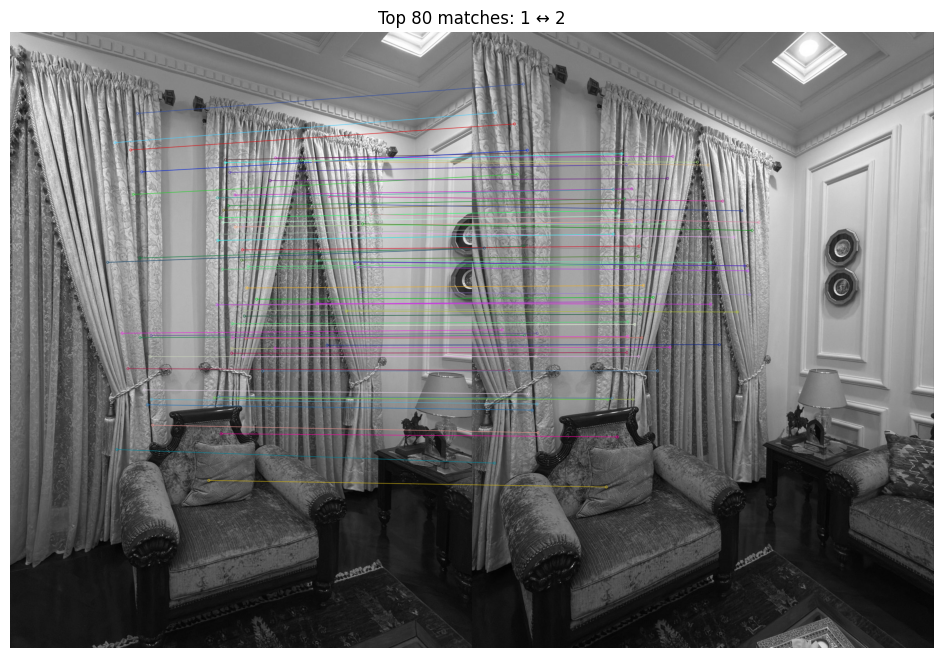

pts1 shape: (2881, 2) pts2 shape: (2881, 2)
[INFO] E inliers: 2595 / 2881
E =
 [[-0.00530767 -0.10414663 -0.01255416]
 [-0.14224814  0.00206461 -0.69252207]
 [ 0.0175911   0.69915683 -0.00351589]]
Recovered R_2 =
 [[ 0.93916826 -0.00646919 -0.34339646]
 [ 0.00742073  0.9999714   0.00145694]
 [ 0.34337721 -0.00391656  0.93918941]]
Recovered t_2 =
 [[ 0.98890616]
 [-0.01867522]
 [ 0.14736294]]


In [174]:
## recovering the pose bw img1 and img2 -> this is the same as phase 2 (copy and pasted)

if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_desc(desc1, desc2, ratio_thresh=0.75):
    """KNN match + Lowe's ratio test."""
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)
    return good

# --- Two-view init: image 1 & 2 ---
i1, i2 = 1, 2
kps1, desc1 = all_kps[i1], all_desc[i1]
kps2, desc2 = all_kps[i2], all_desc[i2]

good_matches = match_desc(desc1, desc2, ratio_thresh=0.75)
print(f"[INFO] 1↔2: {len(good_matches)} good matches")

# Visualize top 80 matches (optional sanity check)
good_sorted = sorted(good_matches, key=lambda m: m.distance)[:80]

img1_vis = load_gray_image(DATASET_DIR, image_names[i1-1])
img2_vis = load_gray_image(DATASET_DIR, image_names[i2-1])

vis12 = cv2.drawMatches(
    img1_vis, kps1,
    img2_vis, kps2,
    good_sorted, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(vis12, cmap='gray')
plt.title("Top 80 matches: 1 ↔ 2")
plt.axis('off')
plt.show()

# --- Build matched point arrays ---
pts1 = np.array([kps1[m.queryIdx].pt for m in good_matches], dtype=np.float64)
pts2 = np.array([kps2[m.trainIdx].pt for m in good_matches], dtype=np.float64)

print("pts1 shape:", pts1.shape, "pts2 shape:", pts2.shape)

# --- Essential matrix with RANSAC ---
E, mask_E = cv2.findEssentialMat(
    pts1, pts2,
    K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)
inliers_E = mask_E.ravel() == 1
print(f"[INFO] E inliers: {np.sum(inliers_E)} / {len(mask_E)}")
print("E =\n", E)

pts1_in = pts1[inliers_E]
pts2_in = pts2[inliers_E]

# --- Recover pose (R, t) ---
_, R_2, t_2, mask_pose = cv2.recoverPose(E, pts1_in, pts2_in, K)
print("Recovered R_2 =\n", R_2)
print("Recovered t_2 =\n", t_2)


In [175]:
# --- Projection matrices for cams 1 & 2 ---
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R_2, t_2])

# Prepare for triangulation: 2×N
pts1_T = pts1_in.T
pts2_T = pts2_in.T

# Triangulate
points_4d = cv2.triangulatePoints(P1, P2, pts1_T, pts2_T)  # 4×N
points_3d = (points_4d[:3] / points_4d[3]).T               # N×3

print("Triangulated points_3d:", points_3d.shape)

# --- Cheirality check: points in front of both cameras ---
X = points_3d.T  # 3×N

# camera 1: [I | 0]
X_cam1 = X
z1 = X_cam1[2, :]

# camera 2: [R_2 | t_2]
X_cam2 = R_2 @ X + t_2
z2 = X_cam2[2, :]

in_front = (z1 > 0) & (z2 > 0)
print("Points in front of both cameras:", np.sum(in_front), "/", X.shape[1])

points_3d_valid = points_3d[in_front]
print("Valid 3D points after cheirality:", points_3d_valid.shape)


Triangulated points_3d: (2595, 3)
Points in front of both cameras: 2594 / 2595
Valid 3D points after cheirality: (2594, 3)


In [176]:
# We'll create a global incremental point_id counter
next_point_id = 0

# Keep only the matches that survived both E RANSAC and cheirality
good_matches_inliers = [m for m, keep in zip(good_matches, inliers_E) if keep]
# Now also apply cheirality (same in_front mask)
good_matches_final = [m for m, keep in zip(good_matches_inliers, in_front) if keep]

print("Final matches used for map points:", len(good_matches_final))
print("points_3d_valid:", points_3d_valid.shape)

assert len(good_matches_final) == points_3d_valid.shape[0]

# Initialize camera poses
cameras[1] = (np.eye(3), np.zeros((3, 1)))  # [I|0]
cameras[2] = (R_2, t_2)

# Fill points3d, observations, keypoint_to_point
for X, m in zip(points_3d_valid, good_matches_final):
    pid = next_point_id
    next_point_id += 1

    # Store 3D point
    points3d[pid] = X

    # Keypoint indices in image 1 and 2
    kp_idx1 = m.queryIdx
    kp_idx2 = m.trainIdx

    # Observations: which image & which keypoint index see this point
    observations[pid] = [(1, kp_idx1), (2, kp_idx2)]

    # Reverse map: kp -> point id
    keypoint_to_point[(1, kp_idx1)] = pid
    keypoint_to_point[(2, kp_idx2)] = pid

print("[INFO] Two-view map initialized:")
print("  Cameras:", list(cameras.keys()))
print("  Num 3D points:", len(points3d))
print("  Example point id 0:", points3d[0] if len(points3d) > 0 else "None")


Final matches used for map points: 2594
points_3d_valid: (2594, 3)
[INFO] Two-view map initialized:
  Cameras: [1, 2]
  Num 3D points: 2594
  Example point id 0: [-1.49232164 -2.5481114   4.88992945]


PHASE 3 STARTS HERE. NOW WE HAVE BOTH CAM[0] AND CAM[1] CALIBRATED

In [177]:
## we need a helper to build 2d -> 3d correspondences for PnP
def build_pnp_correspondences(img_prev, img_curr, matches):
    """
    img_prev: index of previous image
    img_curr: index of current image
    matches: list of cv2.DMatch (prev->curr matches)

    Returns objectPoints (Nx3), imagePoints (Nx2), and matches_pnp (filtered matches)
    """
    obj_pts = []
    img_pts = []
    matches_pnp = []

    for m in matches:
        kp_prev = m.queryIdx  # keypoint in prev image
        key = (img_prev, kp_prev)

        # Does this keypoint correspond to a 3D point already?
        if key in keypoint_to_point:
            pid = keypoint_to_point[key]
            obj_pts.append(points3d[pid])                     # 3D point
            img_pts.append(all_kps[img_curr][m.trainIdx].pt)  # 2D point in new image
            matches_pnp.append(m)

    if len(obj_pts) == 0:
        return None, None, None

    return np.array(obj_pts, dtype=np.float64), \
           np.array(img_pts, dtype=np.float64), \
           matches_pnp


In [178]:
def triangulate_new_points(img_prev, img_curr, matches, R_prev, t_prev, R_curr, t_curr):
    """
    Triangulate new 3D points from matches between img_prev and img_curr.
    Only triangulates points that are not already in the map.
    """
    P_prev = K @ np.hstack([R_prev, t_prev])
    P_curr = K @ np.hstack([R_curr, t_curr])

    new_points = []
    new_matches = []

    pts_prev = []
    pts_curr = []

    for m in matches:
        # If this match already corresponds to a 3D point, skip
        if (img_prev, m.queryIdx) in keypoint_to_point:
            continue

        # Otherwise, prepare for triangulation
        pts_prev.append(all_kps[img_prev][m.queryIdx].pt)
        pts_curr.append(all_kps[img_curr][m.trainIdx].pt)
        new_matches.append(m)

    if len(pts_prev) < 5:
        return []

    pts_prev = np.array(pts_prev).T
    pts_curr = np.array(pts_curr).T

    pts_4d = cv2.triangulatePoints(P_prev, P_curr, pts_prev, pts_curr)
    pts_3d = (pts_4d[:3] / pts_4d[3]).T

    return list(zip(pts_3d, new_matches))


In [179]:
# BFMatcher for all image matching
if use_orb:
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

def match_two_images(desc1, desc2):
    knn = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in knn:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

# Start incremental SfM from image 3 onward
for i in range(3, N_IMAGES + 1):

    print(f"\n[INFO] === Adding image {i} ===")

    prev = i - 1

    # Step 1 — match features prev ↔ i
    matches = match_two_images(all_desc[prev], all_desc[i])
    print(f"Matches between {prev} and {i}: {len(matches)}")

    # Step 2 — build 2D→3D correspondences for PnP
    obj_pts, img_pts, matches_pnp = build_pnp_correspondences(prev, i, matches)

    if obj_pts is None or len(obj_pts) < 6:
        print(f"[WARN] Not enough 2D-3D correspondences for image {i}. Skipping.")
        continue

    # Step 3 — Solve PnP
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        objectPoints=obj_pts,
        imagePoints=img_pts,
        cameraMatrix=K,
        distCoeffs=None,
        reprojectionError=3.0,
        flags=cv2.SOLVEPNP_ITERATIVE
    )

    if not success:
        print(f"[ERROR] PnP failed for image {i}")
        continue

    R_i, _ = cv2.Rodrigues(rvec)
    t_i = tvec.reshape(3,1)

    cameras[i] = (R_i, t_i)
    print(f"[INFO] Camera {i} pose estimated. Inliers:", len(inliers))

    # Step 4 — triangulate new points with prev ↔ i
    R_prev, t_prev = cameras[prev]
    new_pts = triangulate_new_points(prev, i, matches, R_prev, t_prev, R_i, t_i)

    print(f"[INFO] Triangulated {len(new_pts)} new points.")

    # Step 5 — add new points to the map
    global next_point_id

    for (X, m) in new_pts:
        pid = next_point_id
        next_point_id += 1

        points3d[pid] = X
        observations[pid] = [(prev, m.queryIdx), (i, m.trainIdx)]

        keypoint_to_point[(prev, m.queryIdx)] = pid
        keypoint_to_point[(i, m.trainIdx)] = pid

    print(f"[INFO] Total 3D points so far: {len(points3d)}")



[INFO] === Adding image 3 ===
Matches between 2 and 3: 1617
[INFO] Camera 3 pose estimated. Inliers: 272
[INFO] Triangulated 952 new points.
[INFO] Total 3D points so far: 3546

[INFO] === Adding image 4 ===
Matches between 3 and 4: 1781
[INFO] Camera 4 pose estimated. Inliers: 89
[INFO] Triangulated 1482 new points.
[INFO] Total 3D points so far: 5028

[INFO] === Adding image 5 ===
Matches between 4 and 5: 2887
[INFO] Camera 5 pose estimated. Inliers: 256
[INFO] Triangulated 2205 new points.
[INFO] Total 3D points so far: 7233

[INFO] === Adding image 6 ===
Matches between 5 and 6: 2906
[INFO] Camera 6 pose estimated. Inliers: 425
[INFO] Triangulated 1834 new points.
[INFO] Total 3D points so far: 9067

[INFO] === Adding image 7 ===
Matches between 6 and 7: 3096
[INFO] Camera 7 pose estimated. Inliers: 423
[INFO] Triangulated 2190 new points.
[INFO] Total 3D points so far: 11257

[INFO] === Adding image 8 ===
Matches between 7 and 8: 2523
[INFO] Camera 8 pose estimated. Inliers: 565


In [180]:
# Collect all camera centers
cam_indices = sorted(cameras.keys())
cam_centers = []

for i in cam_indices:
    R_i, t_i = cameras[i]
    C_i = -R_i.T @ t_i  # camera center in world coords
    cam_centers.append(C_i.reshape(3))

cam_centers = np.array(cam_centers)  # shape (num_cams, 3)

# Collect all 3D points into a single array
all_points = np.array(list(points3d.values()))
print("Num cameras:", cam_centers.shape[0])
print("Num 3D points:", all_points.shape[0])


Num cameras: 63
Num 3D points: 82944


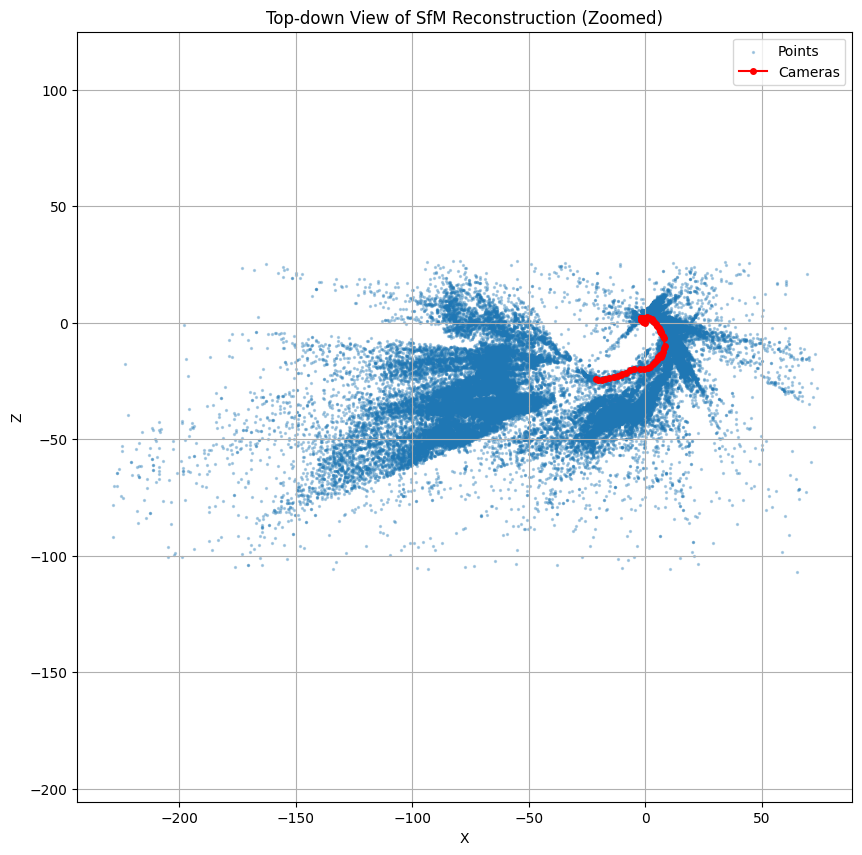

In [181]:
# -------------------------------------------------------
# 1. Filter out extreme outliers (keep central 99%)
# -------------------------------------------------------

low = np.percentile(all_points, 0.5, axis=0)
high = np.percentile(all_points, 99.5, axis=0)

mask = np.all((all_points >= low) & (all_points <= high), axis=1)
filtered_points = all_points[mask]

# -------------------------------------------------------
# 2D top-down view (X vs Z)
# -------------------------------------------------------

plt.figure(figsize=(10, 10))

plt.scatter(filtered_points[:, 0],
            filtered_points[:, 2],
            s=2, alpha=0.3, label="Points")

plt.plot(cam_centers[:, 0],
         cam_centers[:, 2],
         '-o', markersize=4, color='red', label='Cameras')

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down View of SfM Reconstruction (Zoomed)")
plt.legend()
plt.grid(True)
plt.axis('equal')     # keeps scale consistent

plt.show()


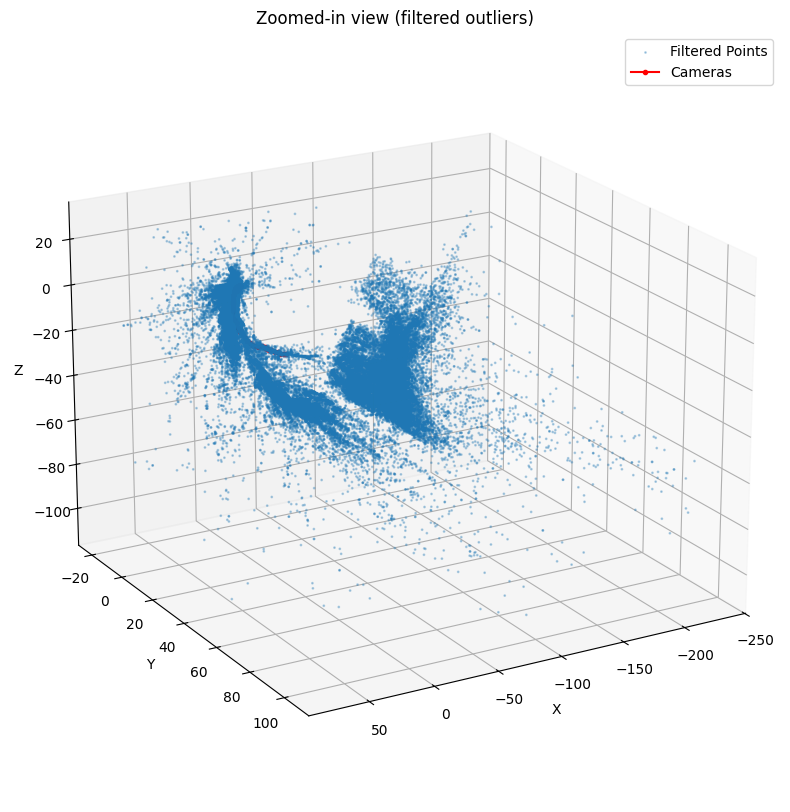

In [182]:
def zoom_point_cloud(all_points, cam_centers, percentile=99):
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    # Compute bounds excluding extreme outliers
    low = np.percentile(all_points, (100-percentile)/2, axis=0)
    high = np.percentile(all_points, 100 - (100-percentile)/2, axis=0)

    mask = np.all((all_points >= low) & (all_points <= high), axis=1)
    filtered = all_points[mask]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(filtered[:,0], filtered[:,1], filtered[:,2],
               s=1, alpha=0.3, label="Filtered Points")

    ax.plot(cam_centers[:,0], cam_centers[:,1], cam_centers[:,2],
            "-o", c="red", markersize=3, label="Cameras")

    ax.set_title("Zoomed-in view (filtered outliers)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.view_init(elev=20, azim=60)
    plt.show()

zoom_point_cloud(all_points, cam_centers)


In [183]:
## these look ass so lets try and refine

In [184]:
import numpy as np
import cv2
from scipy.optimize import least_squares
from scipy.sparse import coo_matrix


In [185]:
# 1) Map cameras to contiguous BA indices 0..num_cams-1
cam_ids = sorted(cameras.keys())
cam_to_ba_idx = {cid: i for i, cid in enumerate(cam_ids)}
num_cams = len(cam_ids)
print("[BA] num_cams =", num_cams)

# 2) Map points to contiguous BA indices 0..num_points-1
point_ids = sorted(points3d.keys())
pid_to_ba_idx = {pid: i for i, pid in enumerate(point_ids)}
num_points = len(point_ids)
print("[BA] num_points =", num_points)

# 3) Build BA observations: (cam_idx_local, pt_idx_local, u_meas, v_meas)
ba_observations = []

for pid in point_ids:
    if pid not in observations:
        continue
    pt_local = pid_to_ba_idx[pid]
    for (img_idx, kp_idx) in observations[pid]:
        if img_idx not in cam_to_ba_idx:
            continue
        cam_local = cam_to_ba_idx[img_idx]
        kp = all_kps[img_idx][kp_idx]
        u_meas, v_meas = kp.pt
        ba_observations.append((cam_local, pt_local, u_meas, v_meas))

ba_observations = np.array(ba_observations, dtype=float)
print("[BA] num_observations =", len(ba_observations))


[BA] num_cams = 63
[BA] num_points = 82944
[BA] num_observations = 165888


In [186]:
def rt_to_params(R, t):
    """R(3x3), t(3x1) -> 6D param (rvec[3], t[3])"""
    rvec, _ = cv2.Rodrigues(R)
    return np.hstack([rvec.flatten(), t.flatten()])


def params_to_rt(p):
    """6D param -> (R, t)"""
    rvec = p[:3].reshape(3, 1)
    t = p[3:].reshape(3, 1)
    R, _ = cv2.Rodrigues(rvec)
    return R, t


# Initial camera parameter array (num_cams, 6)
cam_params_init = np.zeros((num_cams, 6), dtype=np.float64)
for cid, ba_idx in cam_to_ba_idx.items():
    R_i, t_i = cameras[cid]
    cam_params_init[ba_idx] = rt_to_params(R_i, t_i)

# Initial point parameter array (num_points, 3)
point_params_init = np.zeros((num_points, 3), dtype=np.float64)
for pid, pidx in pid_to_ba_idx.items():
    point_params_init[pidx] = points3d[pid]


def pack_params(cam_params, point_params):
    return np.hstack([cam_params.ravel(), point_params.ravel()])


def unpack_params(x):
    params_per_cam = 6
    cam_size = num_cams * params_per_cam

    cam_flat = x[:cam_size]
    pts_flat = x[cam_size:]

    cam_params = cam_flat.reshape((num_cams, params_per_cam))
    point_params = pts_flat.reshape((num_points, 3))

    return cam_params, point_params


x0 = pack_params(cam_params_init, point_params_init)
print("[BA] total parameters =", x0.size)


[BA] total parameters = 249210


In [187]:
def project_point(K, cam_param, point_3d):
    """Project a single 3D point into one camera."""
    R, t = params_to_rt(cam_param)
    X = point_3d.reshape(3, 1)                # (3,1)
    x_cam = R @ X + t                         # camera coords
    z = x_cam[2, 0] + 1e-8                    # avoid /0

    u = K[0, 0] * x_cam[0, 0] / z + K[0, 2]
    v = K[1, 1] * x_cam[1, 0] / z + K[1, 2]
    return u, v


def ba_residuals(x, K, ba_observations):
    """
    Return residuals vector of length 2*M (u,v per observation).
    """
    cam_params, point_params = unpack_params(x)
    residuals = np.empty(2 * len(ba_observations), dtype=np.float64)

    for i, (cam_idx, pt_idx, u_meas, v_meas) in enumerate(ba_observations):
        cam_idx = int(cam_idx)
        pt_idx = int(pt_idx)

        u_pred, v_pred = project_point(K, cam_params[cam_idx], point_params[pt_idx])

        residuals[2 * i]     = u_meas - u_pred
        residuals[2 * i + 1] = v_meas - v_pred

    return residuals


In [188]:
m = 2 * len(ba_observations)       # 2 residuals per observation (u, v)
n = x0.size                        # total params

rows = []
cols = []

for obs_idx, (cam_idx, pt_idx, u_meas, v_meas) in enumerate(ba_observations):
    cam_idx = int(cam_idx)
    pt_idx = int(pt_idx)

    row_u = 2 * obs_idx
    row_v = 2 * obs_idx + 1

    # camera param block indices
    cam_col0 = cam_idx * 6

    # point param block indices
    pt_col0 = num_cams * 6 + pt_idx * 3

    # u residual depends on all 6 cam params
    for j in range(6):
        rows.append(row_u)
        cols.append(cam_col0 + j)
        rows.append(row_v)
        cols.append(cam_col0 + j)

    # and on all 3 point coords
    for j in range(3):
        rows.append(row_u)
        cols.append(pt_col0 + j)
        rows.append(row_v)
        cols.append(pt_col0 + j)

data = np.ones(len(rows), dtype=np.float64)
A = coo_matrix((data, (rows, cols)), shape=(m, n))

print("[BA] Sparsity matrix shape:", A.shape)
print("[BA] Non-zeros:", A.nnz)


[BA] Sparsity matrix shape: (331776, 249210)
[BA] Non-zeros: 2985984


In [189]:
print("[BA] Starting global bundle adjustment...")

result = least_squares(
    ba_residuals,
    x0,
    jac_sparsity=A,
    args=(K, ba_observations),
    method='trf',
    loss='soft_l1',     # robust to outliers
    f_scale=1.0,
    x_scale='jac',
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    max_nfev=30,        # you can try 50 if it's fast enough
    verbose=2
)

print("[BA] Finished. success =", result.success)
print("[BA] Final cost =", result.cost)


[BA] Starting global bundle adjustment...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7885e+06                                    6.22e+10    
       1              5         3.8147e+06      2.97e+06       8.18e+03       1.83e+09    
       2              6         3.6260e+06      1.89e+05       1.67e+03       6.74e+08    
       3              7         2.5123e+06      1.11e+06       1.74e+03       5.01e+06    
       4             10         2.2988e+06      2.14e+05       2.68e+01       4.74e+06    
       5             11         2.1951e+06      1.04e+05       9.33e+00       4.78e+06    
       6             12         2.1504e+06      4.47e+04       8.26e+00       4.59e+06    
       7             13         2.1326e+06      1.78e+04       2.66e+00       4.58e+06    
`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 6.7885e+06, final cost 2.1326e+06, first-order optimality 

In [190]:
cam_params_opt, point_params_opt = unpack_params(result.x)

# Update cameras in global dict (back to original camera IDs)
for cid, ba_idx in cam_to_ba_idx.items():
    R_opt, t_opt = params_to_rt(cam_params_opt[ba_idx])
    cameras[cid] = (R_opt, t_opt)

# Update 3D points in global dict (back to original point IDs)
for pid, pidx in pid_to_ba_idx.items():
    points3d[pid] = point_params_opt[pidx]

print("[BA] Updated cameras and 3D points with optimized values.")


def compute_reprojection_errors(cameras, points3d, K, ba_observations):
    errs = []
    for (cam_idx, pt_idx, u_meas, v_meas) in ba_observations:
        cam_idx = int(cam_idx)
        pt_idx = int(pt_idx)
        # map back to global cam id / point id if you want fairly; here we use BA indices directly
        cam_param = cam_params_opt[cam_idx]  # or reconstruct from cameras if you want
        X = point_params_opt[pt_idx]
        u_pred, v_pred = project_point(K, cam_param, X)
        errs.append(np.sqrt((u_meas - u_pred)**2 + (v_meas - v_pred)**2))
    return np.array(errs)

# Optionally compute BEFORE BA (using x0 & unpack_params(x0))
errs_before = compute_reprojection_errors(cameras, points3d, K, ba_observations)  # using initial cam_params_init / point_params_init
print("[BA] Before: mean =", np.mean(errs_before), "median =", np.median(errs_before))

# AFTER BA, recompute using result.x (or updated cameras/points)
# (You can adapt the function to use 'cameras' + 'points3d' instead of cam_params_opt/point_params_opt)


[BA] Updated cameras and 3D points with optimized values.
[BA] Before: mean = 11.433248299359631 median = 0.591726607324043


In [191]:
# Unpack optimized parameters
cam_params_opt, point_params_opt = unpack_params(result.x)

# Update global cameras dict
for cid, ba_idx in cam_to_ba_idx.items():
    R_opt, t_opt = params_to_rt(cam_params_opt[ba_idx])
    cameras[cid] = (R_opt, t_opt)

# Update global 3D points dict
for pid, pidx in pid_to_ba_idx.items():
    points3d[pid] = point_params_opt[pidx]

print("[BA] Updated cameras and 3D points with optimized values.")


[BA] Updated cameras and 3D points with optimized values.


In [192]:
import numpy as np

# Camera centers
cam_ids = sorted(cameras.keys())
cam_centers = []

for cid in cam_ids:
    R, t = cameras[cid]
    C = -R.T @ t          # camera center in world coords
    cam_centers.append(C.reshape(3))

cam_centers = np.array(cam_centers)

# 3D points (in a consistent order)
point_ids = sorted(points3d.keys())
all_points = np.array([points3d[pid] for pid in point_ids])

print("Num cameras:", cam_centers.shape[0])
print("Num 3D points:", all_points.shape[0])


Num cameras: 63
Num 3D points: 82944


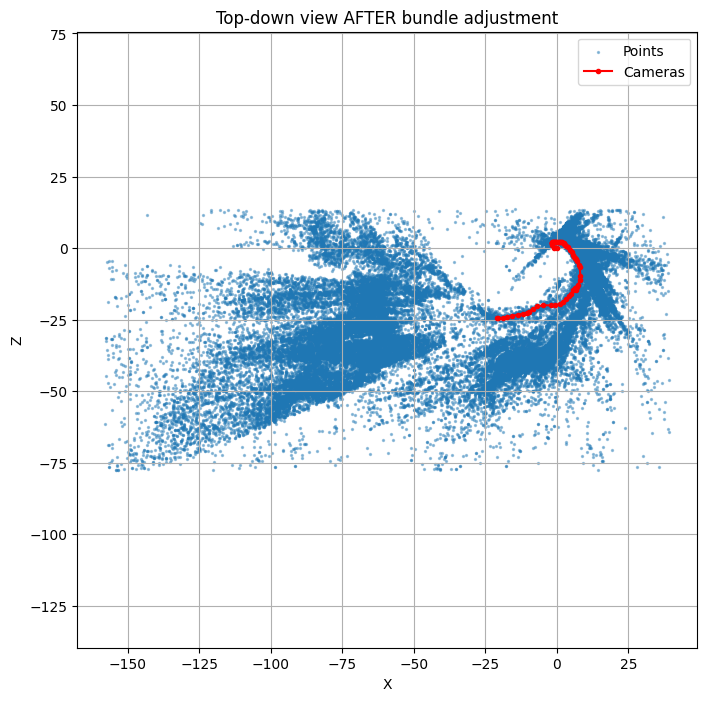

In [193]:
import matplotlib.pyplot as plt

# Optional: filter extreme outliers for nicer view
low = np.percentile(all_points, 1, axis=0)
high = np.percentile(all_points, 99, axis=0)
mask = np.all((all_points >= low) & (all_points <= high), axis=1)
pts_filt = all_points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(pts_filt[:, 0], pts_filt[:, 2],
            s=2, alpha=0.4, label="Points")
plt.plot(cam_centers[:, 0], cam_centers[:, 2],
         "-o", markersize=3, color="red", label="Cameras")

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down view AFTER bundle adjustment")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()


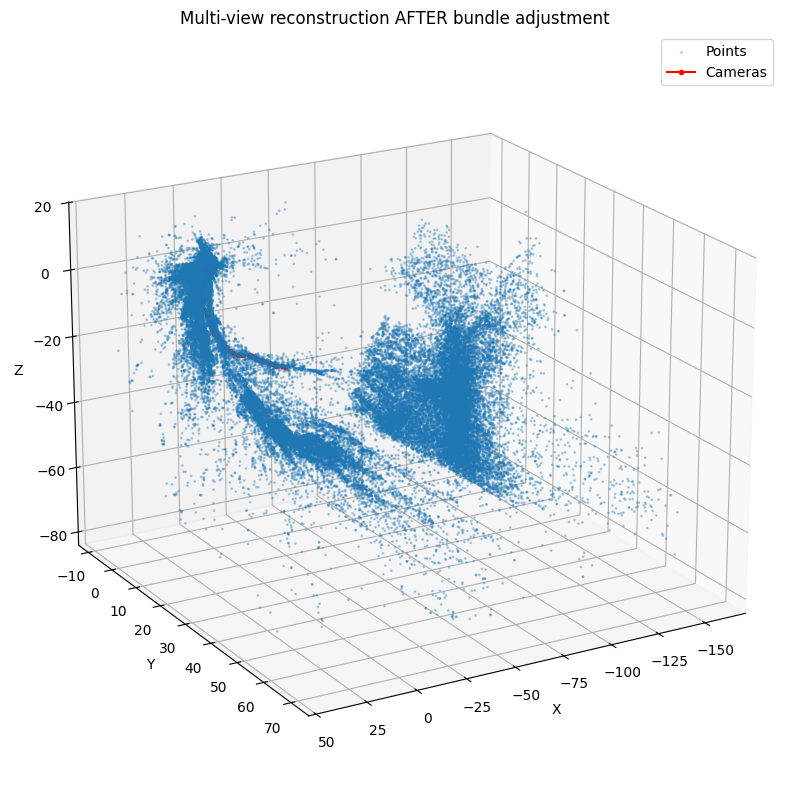

In [194]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(pts_filt[:, 0], pts_filt[:, 1], pts_filt[:, 2],
           s=1, alpha=0.3, label="Points")

ax.plot(cam_centers[:, 0], cam_centers[:, 1], cam_centers[:, 2],
        "-o", markersize=3, color="red", label="Cameras")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Multi-view reconstruction AFTER bundle adjustment")
ax.legend()
ax.view_init(elev=20, azim=60)
plt.show()


[INFO] Plotting 82944 points.
[INFO] Filtered 8295 outliers.


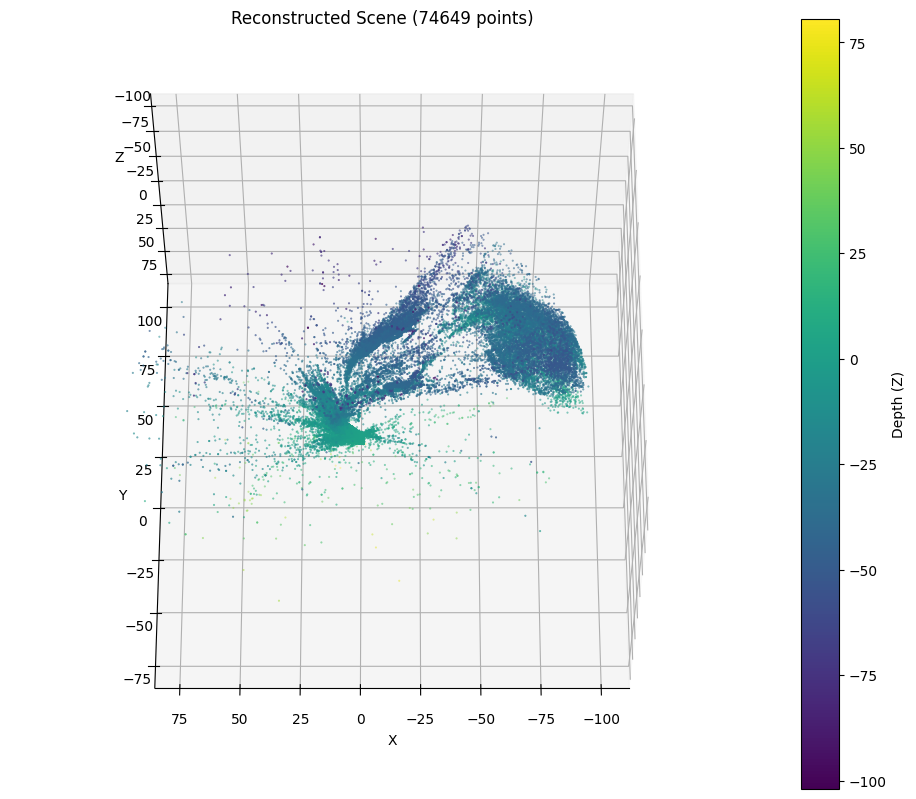

In [195]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- 1. ROBUST DATA EXTRACTION ---
# We calculate the split point based on the known camera count
# Assumes params_per_cam is 6 (Rotation + Translation) based on your previous errors
params_per_cam = 6 
cam_params_end = num_cams * params_per_cam

# Extract the part of the array that belongs to points
points_flat = result.x[cam_params_end:]

# Dynamically reshape: (Whatever_Length_Remains, 3)
points_3d = points_flat.reshape((-1, 3))

print(f"[INFO] Plotting {points_3d.shape[0]} points.")

# --- 2. REMOVE OUTLIERS FOR BETTER VIEWING ---
# Bundle Adjustment can throw some points very far away (outliers).
# We filter points that are too far from the median to keep the plot readable.
center = np.median(points_3d, axis=0)
distances = np.linalg.norm(points_3d - center, axis=1)
# Keep only points within the 90th percentile of distance
mask = distances < np.percentile(distances, 90) 
points_clean = points_3d[mask]

print(f"[INFO] Filtered {len(points_3d) - len(points_clean)} outliers.")

# --- 3. PLOT ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the points
# c=points_clean[:, 2] colors them by depth (Z)
scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                   # Small marker size
    c=points_clean[:, 2],  # Color by depth
    cmap='viridis',
    marker='.'
)

# Formatting
ax.set_title(f"Reconstructed Scene ({len(points_clean)} points)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Force equal aspect ratio (cubic box)
# This prevents the "pancake" effect where the Z-axis looks flattened
all_limits = np.concatenate([points_clean[:,0], points_clean[:,1], points_clean[:,2]])
limit_range = np.ptp(all_limits) / 2
mid_x, mid_y, mid_z = np.mean(points_clean[:,0]), np.mean(points_clean[:,1]), np.mean(points_clean[:,2])

ax.set_xlim(mid_x - limit_range, mid_x + limit_range)
ax.set_ylim(mid_y - limit_range, mid_y + limit_range)
ax.set_zlim(mid_z - limit_range, mid_z + limit_range)

plt.colorbar(scatter, label='Depth (Z)')
# elev = Elevation (up/down angle)
# azim = Azimuth (left/right rotation)
ax.view_init(elev=240, azim=90)
plt.show()

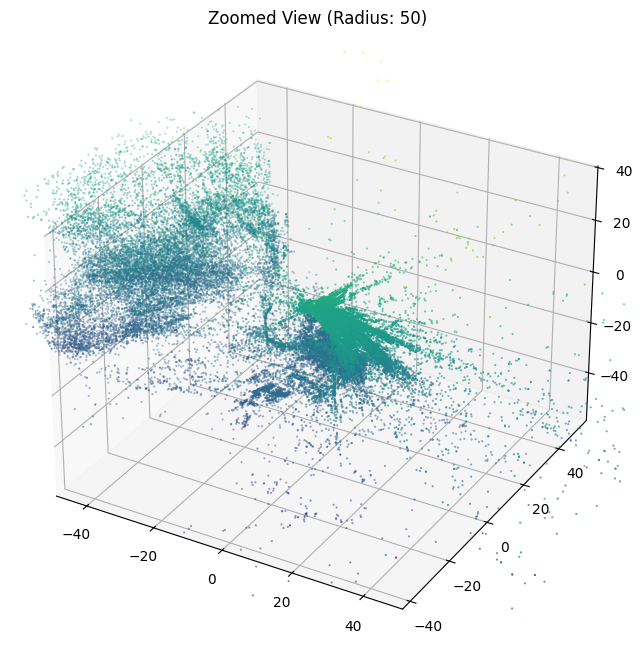

In [196]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CONFIGURATION ---
ZOOM_RADIUS =50 # <--- LOWER this number to zoom in MORE
                   #      HIGHER this number to zoom out

# --- 2. EXTRACT & CENTER ---
# Robust extraction
params_per_cam = 6 
cam_params_end = num_cams * params_per_cam
points_3d = result.x[cam_params_end:].reshape((-1, 3))

# Calculate the center of the cloud (using median to ignore outliers)
center = np.median(points_3d, axis=0)

# --- 3. PLOT ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    points_clean[:, 0], 
    points_clean[:, 1], 
    points_clean[:, 2], 
    s=1,                   # Small marker size
    c=points_clean[:, 2],  # Color by depth
    cmap='viridis',
    marker='.'
)

# --- 4. APPLY ZOOM ---
ax.set_xlim(center[0] - ZOOM_RADIUS, center[0] + ZOOM_RADIUS)
ax.set_ylim(center[1] - ZOOM_RADIUS, center[1] + ZOOM_RADIUS)
ax.set_zlim(center[2] - ZOOM_RADIUS, center[2] + ZOOM_RADIUS)

ax.set_title(f"Zoomed View (Radius: {ZOOM_RADIUS})")

plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_12100\1950467120.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


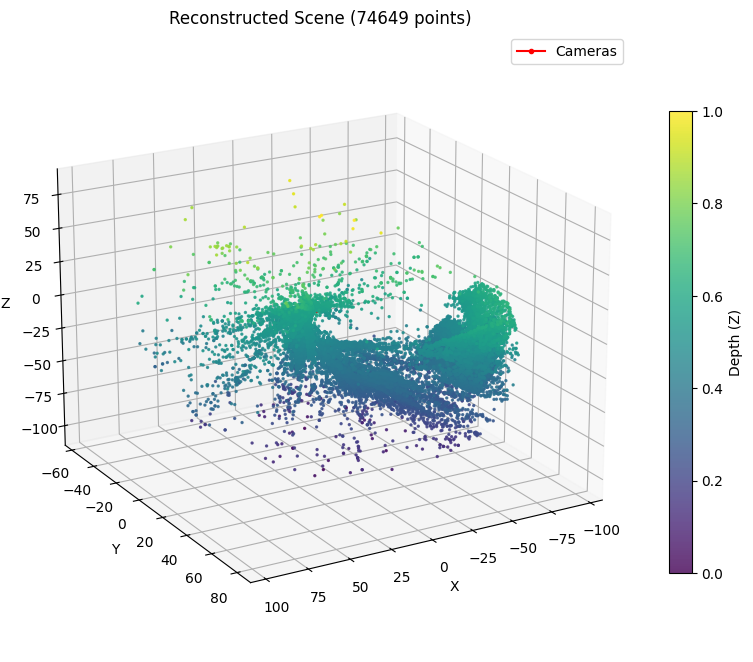

In [197]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

# use your filtered BA points here
pts = points_clean      # e.g., filtered_points or the 7302-point array

# color by depth Z
z = pts[:, 2]
z_min, z_max = z.min(), z.max()
z_norm = (z - z_min) / (z_max - z_min + 1e-8)

cmap = cm.get_cmap('viridis')
colors = cmap(z_norm)  # RGBA, we’ll let matplotlib handle it

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                c=colors, s=2, alpha=0.8)

# optional: draw camera path
ax.plot(cam_centers[:, 0],
        cam_centers[:, 1],
        cam_centers[:, 2],
        '-o', markersize=3, color='red', label='Cameras')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"Reconstructed Scene ({pts.shape[0]} points)")
ax.legend()

cb = fig.colorbar(sc, shrink=0.6)
cb.set_label("Depth (Z)")

ax.view_init(elev=20, azim=60)
plt.show()


In [198]:
import numpy as np
import matplotlib.cm as cm

pts = points_clean  # (N, 3)

# --- compute colors from depth (Z) ---
z = pts[:, 2]
z_min, z_max = z.min(), z.max()
z_norm = (z - z_min) / (z_max - z_min + 1e-8)

cmap = cm.get_cmap('viridis')
colors = cmap(z_norm)[:, :3]           # drop alpha
colors_255 = (colors * 255).astype(np.uint8)

def save_colored_ply(filename, points, colors):
    """
    points: (N, 3) float
    colors: (N, 3) uint8 (0–255)
    """
    N = points.shape[0]
    with open(filename, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        for (x, y, z), (r, g, b) in zip(points, colors):
            f.write(f"{x} {y} {z} {r} {g} {b}\n")

save_colored_ply("sfm_scene_colored_with_intrinsix.ply", pts, colors_255)
print("Saved colored point cloud to sfm_scene_colored.ply")


C:\Users\pc\AppData\Local\Temp\ipykernel_12100\2869294441.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Saved colored point cloud to sfm_scene_colored.ply


In [199]:
def compute_reproj_errors(cam_params, point_params, K, ba_observations):
    errs = []
    for (cam_idx, pt_idx, u_meas, v_meas) in ba_observations:
        cam_idx = int(cam_idx); pt_idx = int(pt_idx)
        u_pred, v_pred = project_point(K, cam_params[cam_idx], point_params[pt_idx])
        err = np.sqrt((u_meas - u_pred)**2 + (v_meas - v_pred)**2)
        errs.append(err)
    return np.array(errs)

cam_params_opt, point_params_opt = unpack_params(result.x)
err_obs = compute_reproj_errors(cam_params_opt, point_params_opt, K, ba_observations)
print("obs error: mean =", err_obs.mean(), "median =", np.median(err_obs))


obs error: mean = 11.433248299359631 median = 0.591726607324043


In [200]:
th = 3.0  # pixels
good_mask = err_obs < th
ba_obs_good = ba_observations[good_mask]
print("[BA] using", len(ba_obs_good), "good obs out of", len(ba_observations))


[BA] using 132936 good obs out of 165888


In [201]:
from scipy.sparse import coo_matrix

ba_obs_good = ba_obs_good  # already computed

m_good = 2 * len(ba_obs_good)           # 2 residuals per observation
n_good = 6 * num_cams + 3 * num_points  # params: 6 per cam, 3 per point

rows = []
cols = []

for obs_idx, (cam_idx, pt_idx, u_meas, v_meas) in enumerate(ba_obs_good):
    cam_idx = int(cam_idx)
    pt_idx = int(pt_idx)

    row_u = 2 * obs_idx
    row_v = 2 * obs_idx + 1

    cam_col0 = cam_idx * 6
    pt_col0 = 6 * num_cams + pt_idx * 3

    # camera params (6)
    for j in range(6):
        rows.append(row_u); cols.append(cam_col0 + j)
        rows.append(row_v); cols.append(cam_col0 + j)

    # point params (3)
    for j in range(3):
        rows.append(row_u); cols.append(pt_col0 + j)
        rows.append(row_v); cols.append(pt_col0 + j)

data = np.ones(len(rows), dtype=np.float64)
A_good = coo_matrix((data, (rows, cols)), shape=(m_good, n_good))

print("[BA-2] Sparsity matrix shape:", A_good.shape)
print("[BA-2] Non-zeros:", A_good.nnz)


[BA-2] Sparsity matrix shape: (265872, 249210)
[BA-2] Non-zeros: 2392848


In [202]:
# cam_params_opt, point_params_opt are from the *first* BA run
x0_good = pack_params(cam_params_opt, point_params_opt)
print("[BA-2] Warm start x0_good size:", x0_good.size)


[BA-2] Warm start x0_good size: 249210


In [203]:
from scipy.optimize import least_squares

print("[BA-2] Starting filtered bundle adjustment...")

result2 = least_squares(
    ba_residuals,
    x0_good,
    jac_sparsity=A_good,
    args=(K, ba_obs_good),
    method='trf',
    loss='cauchy',   # stronger robustness
    f_scale=1.0,
    x_scale='jac',
    ftol=1e-4,
    xtol=1e-4,
    gtol=1e-4,
    max_nfev=40,     # a bit more than before
    verbose=2
)

print("[BA-2] Finished. success =", result2.success)
print("[BA-2] Final cost =", result2.cost)


[BA-2] Starting filtered bundle adjustment...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1896e+04                                    1.74e+06    
       1             22         3.1508e+04      3.88e+02       2.83e+00       1.74e+06    
`xtol` termination condition is satisfied.
Function evaluations 22, initial cost 3.1896e+04, final cost 3.1508e+04, first-order optimality 1.74e+06.
[BA-2] Finished. success = True
[BA-2] Final cost = 31507.51617818345


In [204]:
all_points = np.array([points3d[pid] for pid in sorted(points3d.keys())])
# cam_centers = ...


In [205]:
cam_params_opt2, point_params_opt2 = unpack_params(result2.x)

# update cameras
for cid, ba_idx in cam_to_ba_idx.items():
    R_opt, t_opt = params_to_rt(cam_params_opt2[ba_idx])
    cameras[cid] = (R_opt, t_opt)

# update points
for pid, pidx in pid_to_ba_idx.items():
    points3d[pid] = point_params_opt2[pidx]

print("[BA-2] Updated cameras and 3D points after filtered BA.")


[BA-2] Updated cameras and 3D points after filtered BA.


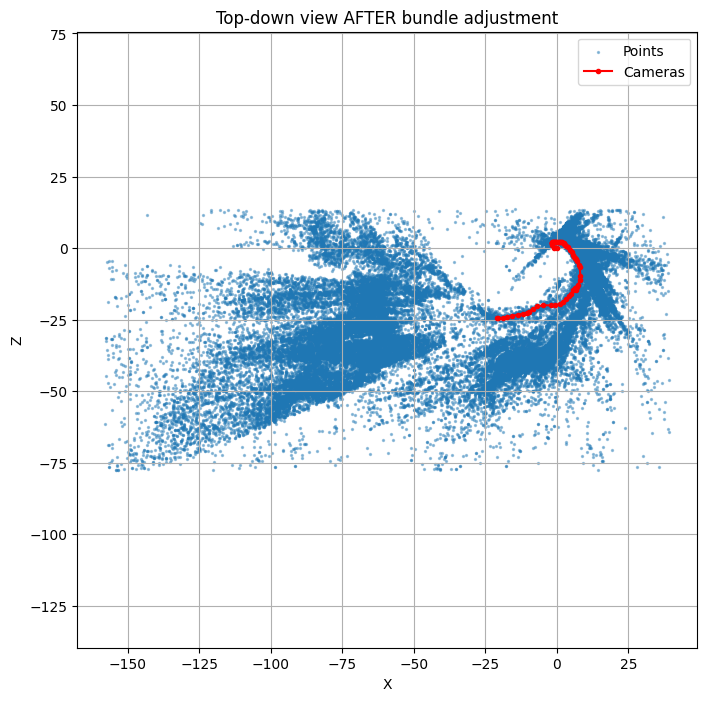

In [ ]:
import matplotlib.pyplot as plt

low = np.percentile(all_points, 1, axis=0)
high = np.percentile(all_points, 99, axis=0)
mask = np.all((all_points >= low) & (all_points <= high), axis=1)
pts_filt = all_points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(pts_filt[:, 0], pts_filt[:, 2],
            s=2, alpha=0.4, label="Points")
plt.plot(cam_centers[:, 0], cam_centers[:, 2],
         "-o", markersize=3, color="red", label="Cameras")

plt.xlabel("X")
plt.ylabel("Z")
plt.title("Top-down view AFTER bundle adjustment")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.show()
